### Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
### Вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
### Вывести сравнение полученных моделей по метрикам бизнеса по показателям с урока
- стоимость лечения 15000р, если сделали тест и начали лечить вовремя
- стоимость лечения 20000р, если упустили и начали лечить когда уже проявились все симптомы
- стоимость теста 1400р

### Сделать выводы о том, какая модель справилась с задачей лучше других
### *Найти порог классификации по деньгам для лучшей модели

_____
_____

Нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 
Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 
Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Ссылка на датасет в [Google Drive](https://drive.google.com/file/d/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G)

скачиваем файл:

In [1]:
!wget 'https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G' -O train_case2.csv

--2023-03-22 23:21:53--  https://drive.google.com/uc?export=download&id=1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G
Resolving drive.google.com (drive.google.com)... 142.250.136.100, 142.250.136.102, 142.250.136.139, ...
Connecting to drive.google.com (drive.google.com)|142.250.136.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8ll3asva8brqdeto9h0o3uneaed6jbrn/1679527275000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download&uuid=82686915-eddb-4de3-9ecd-922da98ee331 [following]
--2023-03-22 23:21:53--  https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8ll3asva8brqdeto9h0o3uneaed6jbrn/1679527275000/14904333240138417226/*/1Si4EJ_RexI3Q7yZU8eLjgp4ORe_BXr4G?e=download&uuid=82686915-eddb-4de3-9ecd-922da98ee331
Resolving doc-00-c0-docs.googleusercontent.com (doc-00-c0-docs.googleusercontent.com)... 173.194.193.132, 

In [2]:
import pandas as pd
import numpy as np
import itertools

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
                             
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def business_threshold_calibrate(y_test, y_score, thresholds,
                                 rubl_test, rubl_late_treatment, rubl_early_treatment):
    business_threshold, r_test_all_r_ML_ = 0, 0
    rubl_ML_ = np.inf
    rs, n = [], 20

    for opt_buisness_tr in np.linspace(0, 1, n).tolist():
        # подберем порог для улучшения бизнесс показателя
        cnf_matrix = confusion_matrix(y_test, y_score > (opt_buisness_tr))
        TN, FN = cnf_matrix[0][0], cnf_matrix[1][0]
        TP, FP = cnf_matrix[1][1], cnf_matrix[0][1]

        rubl_ML = (TP+FP)*rubl_test + FN*rubl_late_treatment + TP*rubl_early_treatment
        
        if rubl_ML < rubl_ML_:            
            business_threshold = opt_buisness_tr
            rubl_ML_ = rubl_ML
        rs.append(rubl_ML)   

    plt.figure(figsize=(11, 5))
    plt.title(f'Расходы при использовании ML-модели: {rubl_ML_}',
              fontweight='bold')
    plt.xlabel('Отсечка')
    plt.ylabel('Потери')
    plt.plot(np.linspace(0,1,n), rs, lw=3, c='#6495ED')
    plt.minorticks_on()
    plt.grid(which='major', linewidth = 2)
    plt.grid(which='minor', linestyle=':');

    return business_threshold

In [20]:
def metrics_and_roc_auc_score(classifier_model, X_train, y_train, X_test, y_test, 
                              cv=7, model_name=''):
    # запустим кросс-валидацию
    cv_scores = cross_val_score(classifier_model, X_train, y_train, cv=cv, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print(f'CV score={cv_score:.4f}+-{cv_score_std:.4f}')

    # обучим пайплайн на всем тренировочном датасете
    classifier_model.fit(X_train, y_train)
    y_score = classifier_model.predict_proba(X_test)[:, 1]

    # Посчитаем precision/recall/f_score:
    b = 1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1 +b**2) * (precision * recall) / (b**2 * precision + recall)

    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print(f'F-Score={fscore[ix]:.4f}\nPrecision={precision[ix]:.4f}\nRecall={recall[ix]:.4f}')

    # Нарисуем roc auc кривую:
    sns.set(font_scale=1.5, style='ticks', palette='pastel')
    sns.set_color_codes("muted")

    plt.figure(figsize=(11, 5))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    plt.plot(fpr, tpr, lw=3, c='#6495ED', label='ROC curve ')
    plt.plot([0, 1], [0, 1], c='#6495ED', lw=3)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name}: ROC curve', fontweight='bold')
    plt.minorticks_on()
    plt.grid(which='major', linewidth = 2)
    plt.grid(which='minor', linestyle=':');
    print('\nплощадь под кривой:')
    print(f'TRAIN: ROC-auc score: {roc_auc_score(y_train, classifier_model.predict_proba(X_train)[:, 1]):.4f}')
    print(f'TEST: ROC-auc score: {roc_auc_score(y_test, classifier_model.predict_proba(X_test)[:, 1]):.4f}\n')

    cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix])
    TN, FN = cnf_matrix[0][0], cnf_matrix[1][0]
    TP, FP = cnf_matrix[1][1], cnf_matrix[0][1]
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    TNR = TN / (FP + TN)
    print(f'{TPR=:.4f}\n{FPR=:.4f}\n{TNR=:.4f}\n')

    busines_tr = business_threshold_calibrate(y_test, y_score, 
                                              thresholds[ix],
                                              rubl_test=1400, 
                                              rubl_early_treatment=15000, 
                                              rubl_late_treatment=20000)

    print(f'уровень порога по бизнес метрике: {busines_tr:.4f}')
    print(f'уровень порога по F1 метрике: {thresholds[ix]:.4f}')

In [5]:
df = pd.read_csv('train_case2.csv', sep=';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


Делим данные на train и test:

In [8]:
from sklearn.utils import shuffle
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='cardio'),
                                                    df['cardio'], random_state=0)

Классы:

In [9]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

К полям:
- ```gender```, ```cholesterol``` применим OHE-кодирование
- ```age```, ```height```, ```weight```, ```ap_hi```, ```ap_lo``` - standardScaler
- ```gluc```, ```smoke```, ```alco```, ```active``` - оставим пока как есть

In [10]:
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

In [11]:
for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))])
    base_transformers.append((base_col, base_transformer))

Объединяем все наши трансформеры с помощью FeatureUnion:

In [12]:
feats = FeatureUnion(continuos_transformers +
                     cat_transformers +
                     base_transformers)
feature_processing = Pipeline([('feats', feats)])

_____
_____

### **Применим к модели LogisticRegression:**

CV score=0.7865+-0.0044
F-Score=0.7303
Precision=0.6474
Recall=0.8376

площадь под кривой:
TRAIN: ROC-auc score: 0.7870
TEST: ROC-auc score: 0.7840

TPR=0.8374
FPR=0.4489
TNR=0.5511

уровень порога по бизнес метрике: 0.3158
уровень порога по F1 метрике: 0.3869


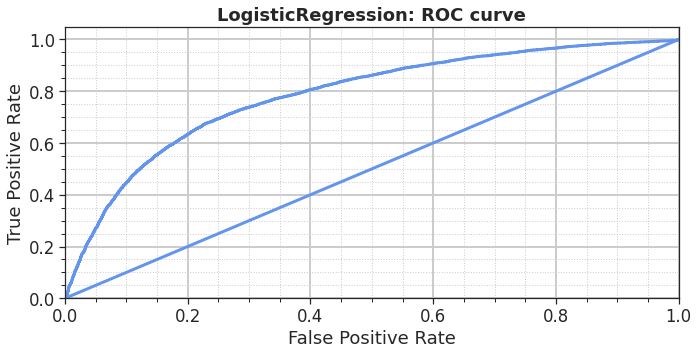

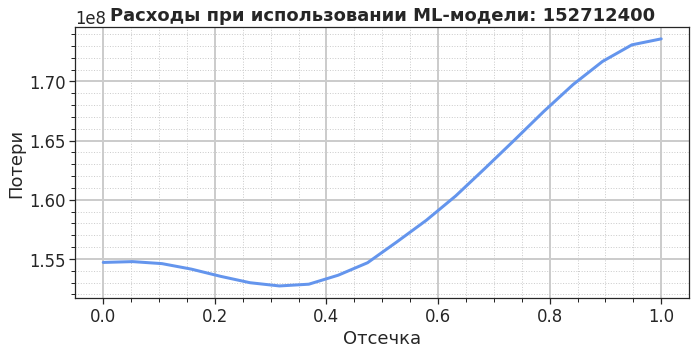

In [21]:
LRclassifier = Pipeline([('features', feats), 
                       ('classifier', LogisticRegression(random_state=42))])
metrics_and_roc_auc_score(LRclassifier, X_train, y_train, X_test, y_test, 
                          model_name='LogisticRegression')

### **Применим к модели KNeighborsClassifier на 5 соседей с учётом веса от расстояния и Евклидовой метрикой:**

CV score=0.6988+-0.0035
F-Score=0.6908
Precision=0.5725
Recall=0.8707

площадь под кривой:
TRAIN: ROC-auc score: 1.0000
TEST: ROC-auc score: 0.6991

TPR=0.8706
FPR=0.6398
TNR=0.3602

уровень порога по бизнес метрике: 0.0000
уровень порога по F1 метрике: 0.2287


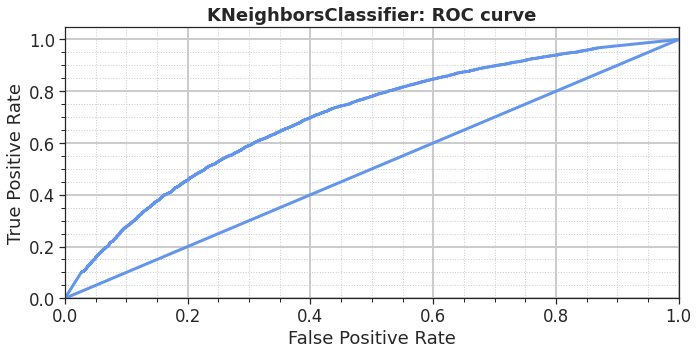

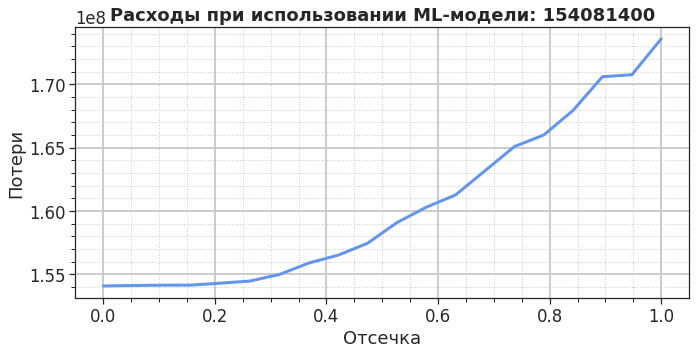

In [14]:
KNclassifier = Pipeline([('features', feats), 
                       ('classifier', KNeighborsClassifier(n_neighbors=6, 
                                                           weights='distance', 
                                                           metric='euclidean'))])
metrics_and_roc_auc_score(KNclassifier, X_train, y_train, X_test, y_test, 
                          model_name='KNeighborsClassifier')

### **Применим к модели RandomForestClassifier на 200 деревьев с глубиной = 8:**

CV score=0.8000+-0.0035
F-Score=0.7397
Precision=0.6666
Recall=0.8308

площадь под кривой:
TRAIN: ROC-auc score: 0.8132
TEST: ROC-auc score: 0.8005

TPR=0.8306
FPR=0.4090
TNR=0.5910

уровень порога по бизнес метрике: 0.3158
уровень порога по F1 метрике: 0.3684


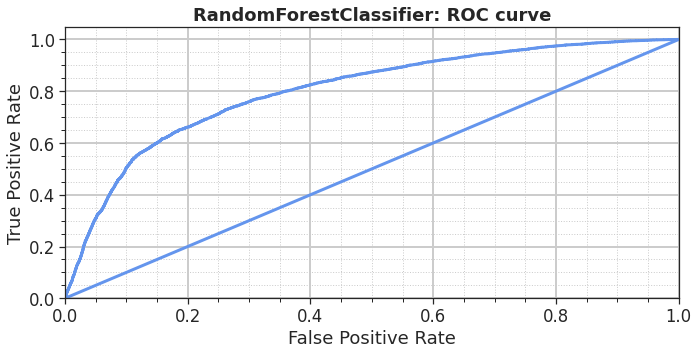

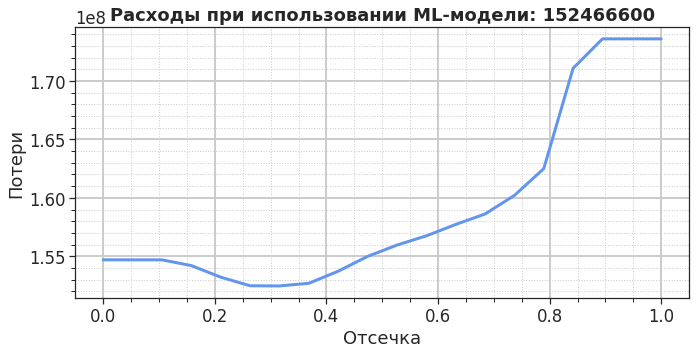

In [15]:
RFclassifier = Pipeline([('features', feats), 
                       ('classifier', RandomForestClassifier(n_estimators=200, 
                                                             max_depth=8, 
                                                             min_samples_split=2, 
                                                             min_samples_leaf=1, 
                                                             max_features='sqrt'))])
metrics_and_roc_auc_score(RFclassifier, X_train, y_train, X_test, y_test, 
                          model_name='RandomForestClassifier')

### **Применим к модели DecisionTreeClassifier:**

CV score=0.7550+-0.0073
F-Score=0.7150
Precision=0.6416
Recall=0.8073

площадь под кривой:
TRAIN: ROC-auc score: 0.8587
TEST: ROC-auc score: 0.7548

TPR=0.7893
FPR=0.4213
TNR=0.5787

уровень порога по бизнес метрике: 0.2105
уровень порога по F1 метрике: 0.3333


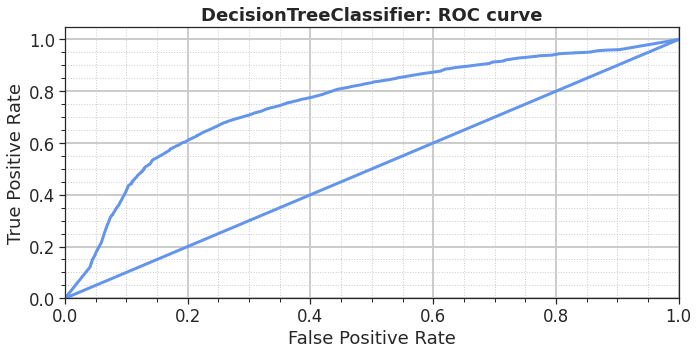

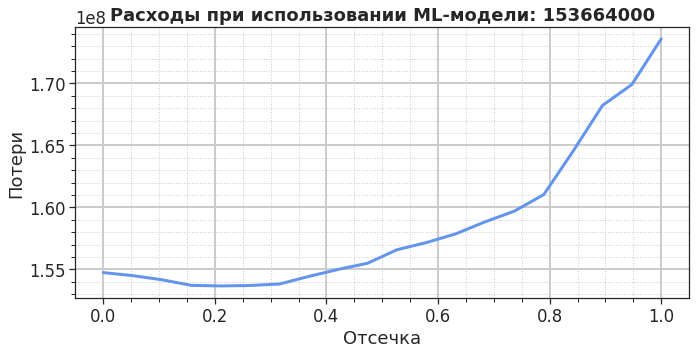

In [16]:
DTclassifier = Pipeline([('features', feats), 
                       ('classifier', DecisionTreeClassifier(splitter='best',
                                                             max_depth=15,
                                                             min_samples_split=5,
                                                             min_samples_leaf=3,
                                                             max_features=5))])
metrics_and_roc_auc_score(DTclassifier, X_train, y_train, X_test, y_test, 
                          model_name='DecisionTreeClassifier')

### **Применим к модели GradientBoostingClassifier:**

CV score=0.8021+-0.0033
F-Score=0.7410
Precision=0.6846
Recall=0.8075

площадь под кривой:
TRAIN: ROC-auc score: 0.8176
TEST: ROC-auc score: 0.8025

TPR=0.8074
FPR=0.3661
TNR=0.6339

уровень порога по бизнес метрике: 0.2632
уровень порога по F1 метрике: 0.3744


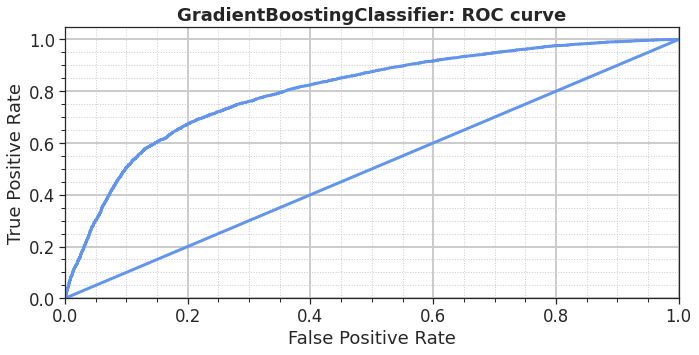

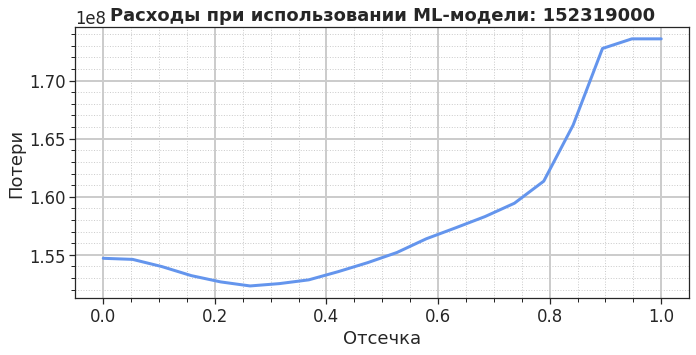

In [17]:
GBclassifier = Pipeline([('features', feats), 
                       ('classifier', GradientBoostingClassifier(n_estimators=150,
                                                                 max_depth=5,
                                                                 min_samples_split=3,
                                                                 max_features=2))])
metrics_and_roc_auc_score(GBclassifier, X_train, y_train, X_test, y_test, 
                          model_name='GradientBoostingClassifier')

_____
_____

Соберём показатели в сводную таблицу:

|  | CV score | Threshold по F1 | Threshold по BM | Precision | Recall | F-Score | TPR | FPR | TNR | расходы |
|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|:--------------:|:--------------:|
| **LogisticRegression** | 0.7865+-0.0044 | 0.3869 | 0.3158 | 0.6474 | 0.8376 | 0.7303 | 0.8374 | 0.4489 | 0.5511 | 152712400 |
| **KNeighborsClassifier** | 0.6988+-0.0035 | 0.2287 | 0.0000 | 0.5725 | 0.8707 | 0.6908 | 0.8706 | 0.6398 | 0.3602 | 154081400 |
| **RandomForestClassifier** | 0.8000+-0.0035 | 0.3684 | 0.3158 | 0.6666 | 0.8308 | 0.7397 | 0.8306 | 0.4090 | 0.5910 | 152466600 |
| **DecisionTreeClassifier** | 0.7550+-0.0073 | 0.3333 | 0.2105 | 0.6416 | 0.8073 | 0.7150 | 0.7893 | 0.4213 | 0.5787 | 153664000 |
| **GradientBoostingClassifier** | 0.8021+-0.0033 | 0.3744 | 0.2632 | 0.6846 | 0.8075 | 0.7410 | 0.8074 | 0.3661 | 0.6339 | 152319000|

Всех меньше расходов приходится на модель с ```GradientBoostingClassifier```, она находит 81% больных, при этом допускает 37% неверных срабатываний и определяет здоровых пациентов как потенциально больных. 

С точки зрения DS такой результат может показаться не самым удачным, однако с добавлением финансовых показателей при таком подходе мы видим лучший финансовый результат. Он достигается за счёт того, что мы фактически тестируем всех, кого модель посчитала склонным к болезни, а такое тестирование обходится там в 1400 р., и дальнейшее лечение тех, у кого болезнь подтверждается и стоит 15000 р., тогда как пациентов с запущенным лечением болезни нам приходится лечить за 20000 р. Отсюда и экономия - лучше "перестраховаться" и промахнуться несколько больше возможного и потратиться на тестирование, чем упустить действительно больных пациентов и платить за их лечение максимальную сумму.